In [1]:
import os, keras
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K

from sklearn.model_selection import train_test_split
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array, array_to_img

Using TensorFlow backend.


In [2]:
#Set some directories
trainHQ_zip_path = '/kaggle/input/carvana-image-masking-challenge/train_hq.zip'
masks_zip_path = '/kaggle/input/carvana-image-masking-challenge/train_masks.zip'

In [3]:
import zipfile
#Extract train images.
with zipfile.ZipFile(trainHQ_zip_path,'r') as zip_ref:
    zip_ref.extractall('/kaggle/working')
#Extract train masks/labels.
with zipfile.ZipFile(masks_zip_path,'r') as zip_ref:
    zip_ref.extractall('/kaggle/working')
data_size = len(os.listdir('/kaggle/working/train_hq'))
print('Number of train images: ', len(os.listdir('/kaggle/working/train_hq')))
print('Number of train masks: ', len(os.listdir('/kaggle/working/train_masks')))

Number of train images:  5088
Number of train masks:  5088


In [4]:
#Display ids for images and masks.
car_ids = sorted(os.listdir('/kaggle/working/train_hq'))
mask_ids = sorted(os.listdir('/kaggle/working/train_masks'))
#Generate some random index.
rnd_ind = list(np.random.choice(data_size,8))
for i in rnd_ind:
    print("Car image id: '{}' -- Corressponding Mask id '{}'".format(car_ids[i], mask_ids[i]))

Car image id: '6e016b8b3617_03.jpg' -- Corressponding Mask id '6e016b8b3617_03_mask.gif'
Car image id: '40851e617b93_15.jpg' -- Corressponding Mask id '40851e617b93_15_mask.gif'
Car image id: 'c2fd64144e97_03.jpg' -- Corressponding Mask id 'c2fd64144e97_03_mask.gif'
Car image id: '11fcda0a9e1c_14.jpg' -- Corressponding Mask id '11fcda0a9e1c_14_mask.gif'
Car image id: '51f1cdf5f539_14.jpg' -- Corressponding Mask id '51f1cdf5f539_14_mask.gif'
Car image id: 'b98c63cd6102_08.jpg' -- Corressponding Mask id 'b98c63cd6102_08_mask.gif'
Car image id: 'bf92e198d9b6_09.jpg' -- Corressponding Mask id 'bf92e198d9b6_09_mask.gif'
Car image id: '6c0cd487abcd_16.jpg' -- Corressponding Mask id '6c0cd487abcd_16_mask.gif'


Image Size:  (1918, 1280)
Mask Size:  (1918, 1280)


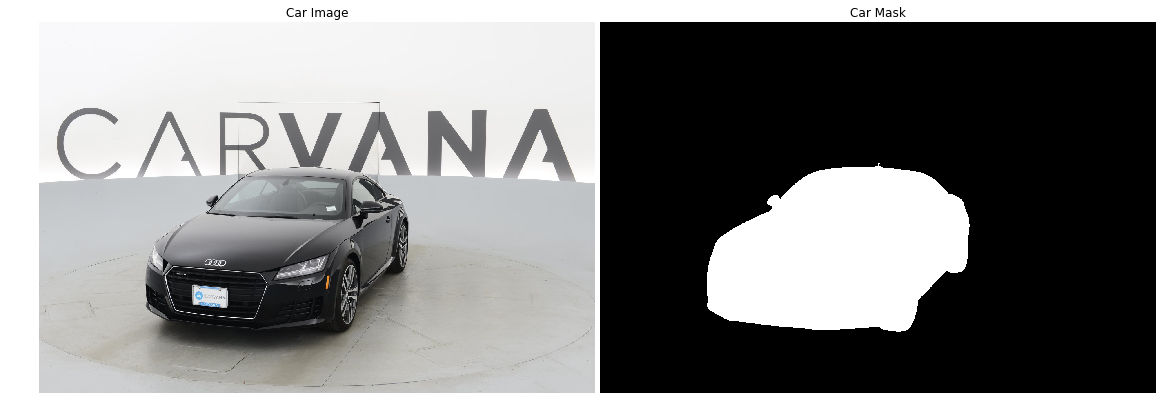

In [5]:
#Pick the 1553th car&mask ids from ids lists.
n = 1553
car_id = car_ids[n]
mask_id = mask_ids[n]
#Load car&mask images using thier ids.
car = load_img('/kaggle/working/train_hq/' + car_id)
mask = load_img('/kaggle/working/train_masks/' + mask_id)
print("Image Size: ", car.size)
print("Mask Size: ", mask.size)
#Plot them.
fig, ax = plt.subplots(1, 2, figsize=(20,20))
fig.subplots_adjust(hspace=.1, wspace=.01)
ax[0].imshow(car)
ax[0].axis('off')
ax[0].title.set_text('Car Image')
ax[1].imshow(mask)
ax[1].axis('off')
ax[1].title.set_text('Car Mask')

In [6]:
#Randomly split car&mask ids list to training and validation lists.
#X is car image ids list, y is mask image ids list.
X_train_ids, X_val_ids, y_train_ids, y_val_ids= train_test_split(car_ids, mask_ids,
                                                                 test_size=.2, train_size=.8,
                                                                 random_state=42)
X_train_size = len(X_train_ids)
X_val_size = len(X_val_ids)
print('Training images size: ', X_train_size)
print('Validation images size: ', X_val_size)

Training images size:  4070
Validation images size:  1018


In [7]:
#Input size could be 128 or 256 or 512 or 1024.
input_size = [128, 128, 3]
def data_generator(images_path, masks_path, image_ids, mask_ids, batch_size, img_size=input_size):
    '''
    images_path/masks_path: Images/Masks folder directory.
    images_ids/mask_ids: Ids for '.jpg' images/masks.
    img_size: Generated imgs/masks size.
    
    returns: batch of randomly-selected car&mask images value-scaled (0 -> 1). 
    '''
    data_size = len(image_ids)
    while True:
        #Choose random indice for later picking.
        rnd_ind = np.random.choice(np.arange(data_size),batch_size)
        imgs = []
        masks = []
        for i in rnd_ind:
            #Pick a random id for car&mask images.
            img_id, mask_id = image_ids[i], mask_ids[i]
            #Load/resize images.
            img = load_img(images_path + img_id, target_size=img_size) 
            mask = load_img(masks_path + mask_id, target_size=img_size[:-1], color_mode = 'grayscale')
            #Add to the batch data.
            imgs.append(img_to_array(img))
            masks.append(img_to_array(mask).reshape(img_size[:-1] + [1]))
        yield np.array(imgs, dtype=np.float16) / 255., np.array(masks, dtype=np.float16) / 255.

In [8]:
#Try out the generator, generate data samples from the validation set.
gen = data_generator('/kaggle/working/train_hq/', '/kaggle/working/train_masks/',
                    X_val_ids, y_val_ids, batch_size=32)

imgs, masks = next(gen)
print('Images batch shape: ', imgs.shape)
print('Masks batch shape: ', imgs.shape)

Images batch shape:  (32, 128, 128, 3)
Masks batch shape:  (32, 128, 128, 3)


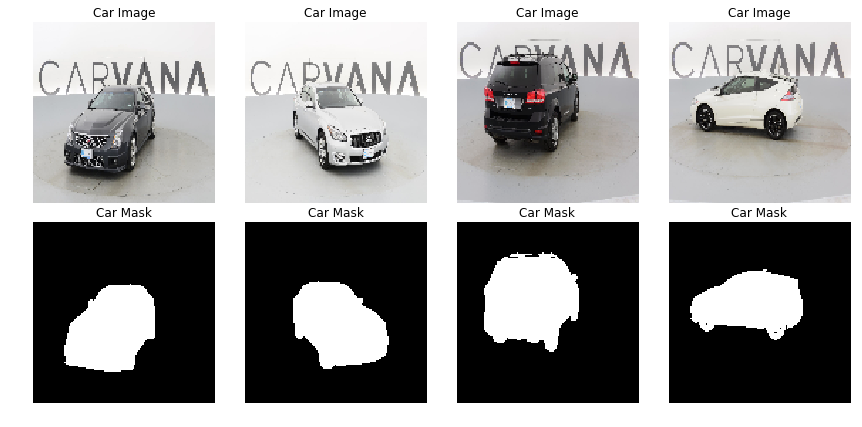

In [9]:
#Plot output samples of the generator.
fig, ax = plt.subplots(2, 4, figsize=(15,7))
fig.subplots_adjust(hspace=.1, wspace=.05)
car_samples, mask_samples = imgs[:4].astype(np.float32), masks[:4][:,:,:,0].astype(np.float32)
for i, (car, mask) in enumerate(zip(car_samples, mask_samples)):
    ax[0, i].imshow(car)
    ax[0, i].axis('off')
    ax[0, i].title.set_text('Car Image')
    
    ax[1, i].imshow(mask, cmap='gray')
    ax[1, i].axis('off')
    ax[1, i].title.set_text('Car Mask')
plt.show() 

In [10]:
def dice_coef(y_true, y_pred):
    '''
    Metric
    '''
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    '''
    Loss function
    '''
    loss = 1 - dice_coef(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    '''
    Mixed crossentropy and dice loss.
    '''
    loss = keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [15]:
def get_unet_128(input_shape=(128, 128, 3),
                 num_classes=1):
    inputs = Input(shape=input_shape)
    # 128

    down1 = Conv2D(64, (3, 3), padding='same')(inputs)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    # 64

    down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
    # 32

    down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
    # 16

    down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
    # 8

    center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(1024, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    # center

    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    # 16

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    # 32

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    # 64

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    # 128

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up1)

    model = Model(inputs=inputs, outputs=classify)

    model.compile(optimizer=RMSprop(lr=0.0001), loss=bce_dice_loss, metrics=[dice_coef])

    return model

uNet = get_unet_128()

In [16]:
#Prepare callbacks
LR_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=10, factor=.2, min_lr=.00001)
EarlyStop_callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True)

In [17]:
#Perpare data generators.
batch_size = 32
train_gen = data_generator('/kaggle/working/train_hq/', '/kaggle/working/train_masks/',
                           X_train_ids, y_train_ids, batch_size=batch_size)
val_gen = data_generator('/kaggle/working/train_hq/', '/kaggle/working/train_masks/',
                           X_val_ids, y_val_ids, batch_size=batch_size)

In [18]:
history = uNet.fit_generator(train_gen, steps_per_epoch=int(X_train_size/batch_size),
                             epochs=2, validation_data=val_gen,
                             validation_steps=int(X_val_size/batch_size),
                             callbacks=[LR_callback, EarlyStop_callback])

Epoch 1/2
127/127 [==============================] - 222s 2s/step - loss: 0.3441 - dice_coef: 0.7957 - val_loss: 1.3671 - val_dice_coef: 0.1746
Epoch 2/2
127/127 [==============================] - 204s 2s/step - loss: 0.1969 - dice_coef: 0.8742 - val_loss: 1.5340 - val_dice_coef: 0.1004


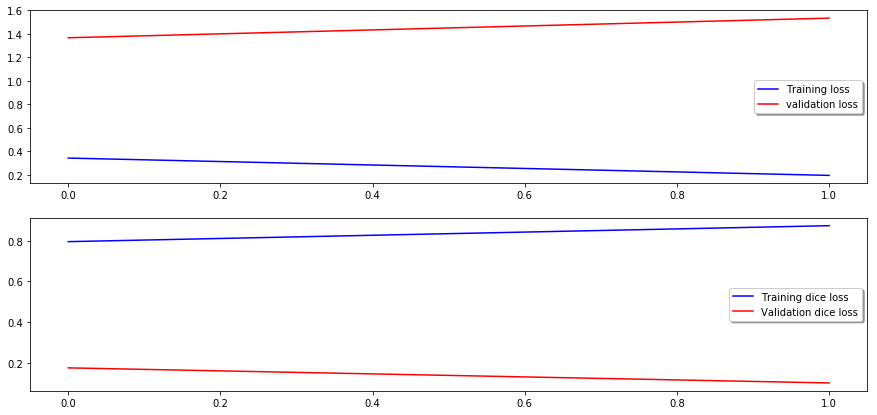

In [19]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1, figsize=(15,7))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['dice_coef'], color='b', label="Training dice loss")
ax[1].plot(history.history['val_dice_coef'], color='r',label="Validation dice loss")
legend = ax[1].legend(loc='best', shadow=True)

1. * Now let's try  to pridect masks for a batch of 32 images from the validation set.

In [20]:
#Perdict some imgs.
pred_masks = uNet.predict(imgs)

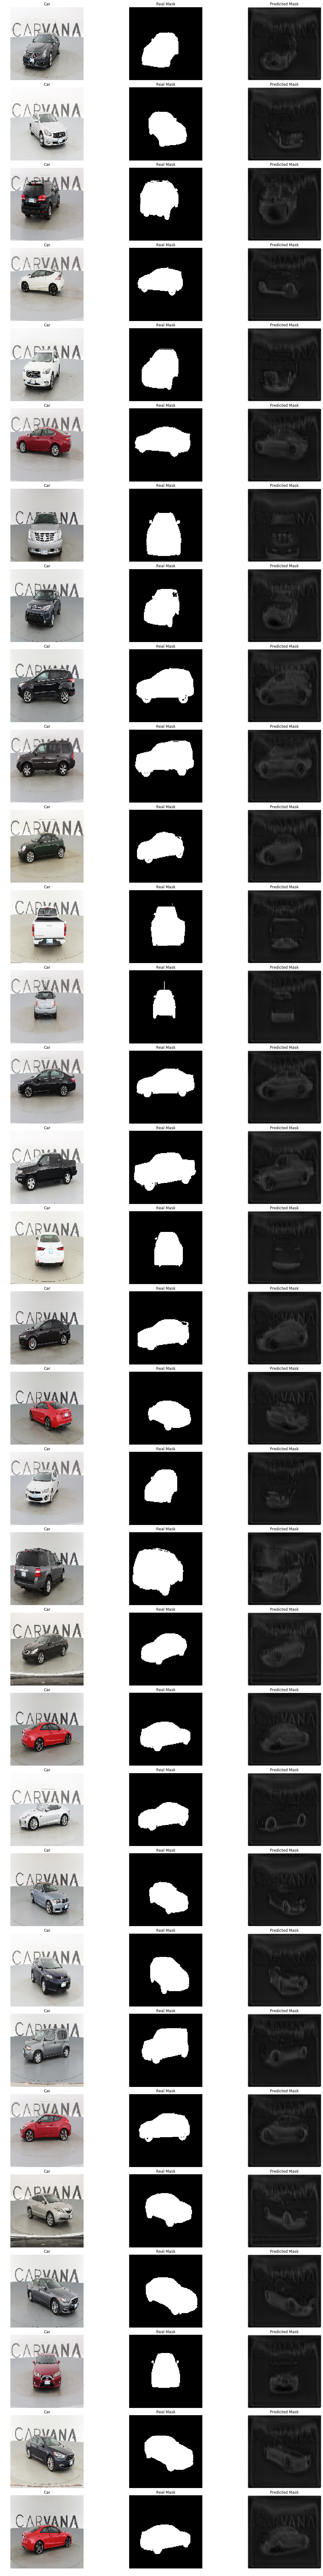

In [21]:
fig, ax = plt.subplots(32, 3, figsize=(20,150))
fig.subplots_adjust(hspace=.1, wspace=.05)
for i in range(32):
    ax[i, 0].imshow(imgs[i].astype(np.float32))
    ax[i, 0].axis('off')
    ax[i, 0].title.set_text('Car')
    
    ax[i, 1].imshow(masks[i,:,:,0].astype(np.float32), cmap='gray')
    ax[i, 1].axis('off')
    ax[i, 1].title.set_text('Real Mask')
    
    ax[i, 2].imshow(pred_masks[i,:,:,0], cmap='gray')
    ax[i, 2].axis('off')
    ax[i, 2].title.set_text('Predicted Mask')
plt.show() 

In [ ]:
import shutil
shutil.rmtree('/kaggle/working/train_hq')
shutil.rmtree('/kaggle/working/train_masks')